In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 13
from IPython.display import display, HTML, Image as IMM
from PIL import Image
from copy import deepcopy
from tqdm.notebook import tqdm

### Maze definition

In [5]:
class BuildMaze(): 
    """ Defines a maze with variable dimensions. The maze includes special cells of 'Blocks,' 
    through which one cannot go, 'Holes,' which teleport one back to start, and 'Food' which 
    elevates one's score. Block, hole, and food locations are defined randomly according to 
    the desired fractions of those cells. Start and goal locations are at the top left and 
    bottom right, respectively."""
    
    def __init__(self, rows, cols, cell_fractions, seed=10):
        self.rows = rows # maze row count
        self.cols = cols # maze column count
        self.cell_fractions = cell_fractions # list of block, hole, and food fractions, e.g., [0.3,0.1,0.1]
        self.start = [0,0] # start at top left
        self.goal = [self.rows-1,self.cols-1] # exit at bottom right
        self.seed = seed #fixes the maze structure for a given configuration 
    
    def special_cells(self): 
        """Based on the maze dimensions and desired cell fractions, returns the (row index, column 
        index) for each special cell. The output is a list of 3 lists, containing the index tuples 
        for blocks, holes, and food respectively."""
        
        np.random.seed(self.seed)
        
        # Create a 2D array of zeros 
        array_2d = np.zeros((self.rows, self.cols), dtype=int) 
        
        # Calculate total number of special cells 
        total_fraction = np.sum(self.cell_fractions) # <1
        num_cells = int(total_fraction * self.rows * self.cols)  
        
        # Random list of special cell 1D indices (replace=False --> each index used only once)
        indices = np.random.choice(self.rows * self.cols, num_cells, replace=False) 
        
        # Randomly choose Block 1D indices out of all special cell 1D indices
        num_blocks = int(self.cell_fractions[0]*self.rows * self.cols)
        blocks = np.random.choice(indices,num_blocks,replace=False)
        
        # Randomly choose Hole 1D indices out of remaining special cell 1D indices
        remaining_indices = [x for x in indices if x not in blocks]
        num_holes = int(self.cell_fractions[1]*self.rows * self.cols)
        holes = np.random.choice(remaining_indices,num_holes, replace=False)
        
        # Food 1D indices are just the remaining special 1D indices
        food = [y for y in remaining_indices if y not in holes]

        # Convert each 1D special cell index to a 2D special cell index         
        Z=[[],[],[]]
        i=0
        for L in [blocks, holes, food]:
            row_indices = np.array(L) // self.cols #integer division to get the row index lists
            col_indices = np.array(L) % self.cols #modulo operator to get the column index lists  
            
            # Make (row,column) tuples for each special cell
            rowi, coli = [], []
            for k in range(len(row_indices)):
                # We do not want special cells right next to start and end points to ensure no blockage
                if (row_indices[k]>1 or col_indices[k]>1) and (row_indices[k]<self.rows-2 or col_indices[k]<self.cols-2):
                    rowi.append(row_indices[k])
                    coli.append(col_indices[k])
                    
            Z[i] = [(rowi[i], coli[i]) for i in range(len(rowi))]
            i += 1
        
        return Z #e.g., [[(2, 0), (0, 3), (0, 2)], [(1, 3)], [(1, 2)]] for a 4x4 maze
    

    def maze_rgb(self, pos=False, traj = False):
        """Returns an RGB array representation of maze, of shape (rows, cols, 3)."""
        
        # create a 3D array, whose RGB view is a full gray canvas (with each element = 220)
        backgr = np.ones(shape = [self.rows,self.cols,3], dtype=np.uint8)*220
        
        # assign 'cyan' to start and goal locations
        backgr[self.start[0]][self.start[1]] = [0, 255, 255] 
        backgr[self.goal[0]][self.goal[1]] = [0, 255, 255]
        
        # assign 'blue' to agent's location if pos flag is on
        if pos:
            backgr[pos[0]][pos[1]] = [0,0,255]
               
        # assign 'black', 'red', and 'green' to blocks, holes, and food cells, respectively
        for b in self.blocks:
            backgr[b[0]][b[1]] = [0,0,0]
        for h in self.holes:
            backgr[h[0]][h[1]] = [255,0,0]
        for f in self.food:
            backgr[f[0]][f[1]] = [50, 205, 50]
        
        # assign 'cyan' to agent's trajectory (except the start and goal locations) if traj flag is on
        if traj:
            for i in range (1,len(traj)-1):
                backgr[traj[i][0]][traj[i][1]] = [0, 255, 255]
        
        return backgr #(rows,cols,3)
    
    def scaled_maze_rgb(self, pos=False, traj=False):
        """Scales up the rows and cols of maze's RGB array by 25x so that they get 
        visible once converted to image."""

        image_scale_factor = 25
        scene = self.maze_rgb(pos,traj).repeat(image_scale_factor, axis=0).repeat(image_scale_factor, axis=1)
        grid_spacing = image_scale_factor
        
        # Add vertical gridline
        for x in range(0, scene.shape[1], grid_spacing):
            scene[:, x:x + 1] = [255, 255, 255]  
        
        # Add horizontal gridline
        for y in range(0, scene.shape[0], grid_spacing):
            scene[y:y + 1, :] = [255, 255, 255]  
        
        return scene #(rows x 25,cols x 25,3)
    
    def rgb_view(self,pos=False,traj=False):
        """Returns RGB view of maze using the scaled RGB value array."""
        
        return Image.fromarray(self.scaled_maze_rgb(pos,traj), 'RGB') 

    def make_gif(self,frames, path): 
        """Creates a GIF file at the specified path containing all the frames from the frames list."""

        frame_one = frames[0]
        
        # 300 msec/frame, looping indefinitely
        frame_one.save(path, format="GIF", append_images=frames, save_all=True, duration=300, loop=0)

### Environment class

In [6]:
class Env_Maze(BuildMaze):
    """Initiates the environment and subscribes its steps."""
    
    def __init__(self,rows, cols, cell_fractions,seed_env):
        super().__init__(rows, cols, cell_fractions,seed_env)
        [self.blocks,self.holes,self.food] = super().special_cells() 
        
     
    def loc_to_state(self, loc):
        """Returns the state index based on grid cell location (x, y)."""
        
        return self.cols*loc[0]+loc[1]
       
        
    def env_start(self):
        """The first method called when the episode starts, before the start of agent. 
        Returns the first state from the environment."""
        
        reward = 0
        self.total_reward = 0
        self.current_pos = self.start #[0,0]
        self.current_state = self.loc_to_state(self.current_pos)
        terminal = False 
        self.R_S_term = (reward, self.current_state, terminal)
        
        return self.current_state
    
    
    def env_step(self, action):
        """Environment's reaction to agent's action (i.e., move to either left, right, up, or down) 
        in terms of the reward, new state, and terminal flag. Reward = -1 for each move except 
        it is -10 for falling into holes, and 10 for finding food."""

        new_pos = deepcopy(self.current_pos)

        # First find the new coordinate by disregarding the special cells
        # While making sure to stay within the maze boundaries
        if action == 0: #right
            new_pos[1] = min(new_pos[1]+1, self.cols-1)
        elif action == 1: #up
            new_pos[0] = max(new_pos[0]-1, 0)
        elif action == 2: #left
            new_pos[1] = max(new_pos[1]-1, 0)
        elif action == 3: #down
            new_pos[0] = min(new_pos[0]+1, self.rows-1)
        else:
            raise Exception("Invalid action.")

        # Starting assumptions: did not hit the Goal state nor a special cell        
        terminal = False
        reward = -1.0
        
        # Stay in place if the action led to any blocks (still with reward = -1)
        if tuple(new_pos) in self.blocks: 
            new_pos = deepcopy(self.current_pos)
            
        # Reward = 100 for finding food, once eaten, the food is gone
        elif tuple(new_pos) in self.food:
            reward = 10
            self.food = [t for t in self.food if t != tuple(new_pos)] 

        # Reward = -100 for falling into a hole, and the agent is sent back to start position
        elif tuple(new_pos) in self.holes:
            reward = -10
            new_pos = deepcopy(self.start)

        # Reaching the goal state turns the terminal flag on (reward = -1)
        elif new_pos == self.goal:
            terminal = True

        self.current_pos = new_pos
        self.current_state = self.loc_to_state(self.current_pos) 
        self.total_reward += reward
        self.R_S_term = (reward, self.current_state, terminal)
        
        return self.R_S_term 

### Agent class

In [7]:
class Agent_TD():
    """Describes the TD Agent's behavior according to 3 TD learning algorithms."""
    
    def __init__(self, num_states, epsilon, discount, step_size, seed_agent):
             
        self.num_actions = 4 # left, right, up, down
        self.num_states = num_states # total number of cells in the maze
        self.epsilon = epsilon # for epsilon-greedy action selection
        self.gamma = discount # discount factor
        self.alpha = step_size # learning rate
        self.rand_generator = np.random.RandomState(seed_agent) # controlling the randomness in agent's moves   
        self.q = np.zeros((self.num_states, self.num_actions)) # starting action-values all zero
                     
   
    def argmax(self, q_values):
        """Argmax function with random tie-breaking (vs. the deterministic method in numpy)"""
        
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []
            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties) # controlled by seed_agent
    
    
    def select_action_epsilon_greedy(self, current_q):   
        """Epsilon-greedy action selection. If generated number < epsilon, the agent 
        takes a random action, otherwise selects the action with the highest Q-value 
        available at the particular state the agent is in."""

        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions) # controlled by seed_agent
        else:
            action = self.argmax(current_q)
        
        return action
    
    
    def probs_epsilon_soft(self, current_q):
        """Returns the probabilities for action selection according to epsilon-soft policy.
        Ensures all actions to have some probability while the greedy action is favored."""
        
        # Find the index of the action with the highest Q-value
        idxmax = self.argmax(current_q)
        
        # Initialize the probability distribution ensuring that all actions have a chance to be selected.
        probs = [(self.epsilon/self.num_actions) for i in range(self.num_actions)]
        
        # Increase the selection probability of the action with idxmax while ensuring total probs = 1 
        probs[idxmax]+=1-self.epsilon
        
        return probs
    
            
    def agent_start(self, current_state):
        """ Samples/returns the first action at the first state (from env_start) 
        using epsilon-greedy policy"""
   
        current_q = self.q[current_state,:]
        action = self.select_action_epsilon_greedy(current_q)
        
        self.prev_state = current_state
        self.prev_action = action
        
        return action
    
       
    def agent_step(self, algorithm, reward, current_state):
        """ Updates the value of the previous action using one of the 3 TD algorithms. 
        Other arguments are reward and state from env_step. Samples and returns an  
        action using the epsilon-greedy policy."""

        # Action values at the current state:
        current_q = self.q[current_state,:]
        
        # Epsilon-greedy action selection
        action = self.select_action_epsilon_greedy(current_q)

        # Identify the 'target' according to TD control algorithm
        
        if algorithm == "SARSA": 
            target = reward + self.gamma*self.q[current_state, action]
        
        elif algorithm == "Expected SARSA":  
            probs =  self.probs_epsilon_soft(current_q)
            target = reward + self.gamma*np.sum(np.array(probs)*np.array(current_q))
            
        elif algorithm == "Q-Learning": 
            target = reward + self.gamma*np.max(current_q)
            
        # Update the value of the previous action using a common update equation for all algorithms
        self.q[self.prev_state, self.prev_action]+=self.alpha*(target-self.q[self.prev_state, self.prev_action])
        
        self.prev_state = current_state
        self.prev_action = action
        
        return action


    def agent_end(self, reward): 
        """ Updates the value of the previous action while at the terminal state (with 
        zero action-value). Reward from the latest env_step is the only argument. Does 
        not return an action.
        """
        
        # Same target for all algorithms since current_q = 0
        target = reward 
        
        self.q[self.prev_state, self.prev_action]+=self.alpha*(target-self.q[self.prev_state, self.prev_action])

### RL loop definition

In [8]:
class RL(Env_Maze, Agent_TD):
    """ Implements the RL loop by combining the env and agent classes."""

    def __init__(self, rows, cols, cell_fractions,seed_env, 
                 epsilon, discount, step_size, seed_agent):
        super().__init__(rows, cols, cell_fractions,seed_env)
        Agent_TD.__init__(self, rows*cols, epsilon, discount, step_size, seed_agent)
            
            
    def episode(self, algorithm):
        """ Runs a single episode, based on the TD control algorithm, from env_start to agent_end. 
        Returns the score and episode length."""
        
        # The first state, as returned by env_start
        current_state = self.env_start() 
        
        # Start the trajectory, scores (cumulative reward), and RGB frames lists) 
        self.traject=[tuple(self.current_pos)] 
        score = 0
        self.fr = [(Image.fromarray(self.scaled_maze_rgb(pos=tuple(self.current_pos), traj=False), 'RGB'))]
        
        # Take the first epsilon-greedy action according to agent_start
        action = self.agent_start(current_state)
        
        # Environment's first step, returning the new state and reward for the previous action
        (reward, current_state, term) = self.env_step(action)
        
        # Add the first position, reward, and frame 
        self.traject.append(tuple(self.current_pos)) 
        score += reward
        self.fr.append(Image.fromarray(self.scaled_maze_rgb(pos=tuple(self.current_pos), traj=False), 'RGB'))
        
        # As long as terminal state is not reached:
        while term == False:

            # Next action according to agent_step
            action = self.agent_step(algorithm, reward, current_state) 
            
            # Next environment step per env_step
            (reward, current_state, term) = self.env_step(action)  
            
            # Add the new position, score, and frame
            self.traject.append(tuple(self.current_pos))
            score += reward
            self.fr.append(Image.fromarray(self.scaled_maze_rgb(pos=tuple(self.current_pos), traj=False), 'RGB'))
            
        # Finalize the episode by updating the latest action value according to agent_end
        self.agent_end(reward) 
        
        return score, len(self.traject)
        
        
    def run_exp(self, algorithm, num_episodes, save_fr):
        """ Runs a single experiment based on the TD control algorithm and number of episodes.
        Returns the scores list and episode length list for all episodes."""
        
        # Dictionaries or lists to hold the trajectories, cumulative rewards, episode lengths, and frames 
        self.traj_dict={}
        scores = []
        episode_lengths = []
        self.fr_dict={} 
        
        # Start from episode 1
        for episode in range(1, num_episodes + 1):
            
            # Run an episode
            score, episode_length = self.episode(algorithm)
            
            # Replenish the food cells which may be consumed during the previous episode
            self.food = super().special_cells()[2]
            
            # Save the trajectory and scores in their respective lists
            scores.append(score)
            episode_lengths.append(episode_length)
            
            # Save the trajectories and frames only after the first and the last episodes
            if (episode ==1 or episode == num_episodes) and save_fr==True:
                self.traj_dict[episode]=self.traject 
                self.fr_dict[episode]=self.fr           
        
        # Replenish the food cells which may be consumed during the last episode
        self.food = super().special_cells()[2]
        
        return scores, episode_lengths    

### Plotting functions

In [14]:
def plot_episodes(num_episodes,A,B):    
    """Shows the scores and number of steps vs. training episodes for 3 TD control algorithms."""
    
    plt.figure(figsize=(12, 4))
    plt.grid(linestyle='--', linewidth=0.7) 

    for algo in ["Q-Learning", "SARSA", "Expected SARSA"]:
        plt.subplot(1, 2, 1)
        plt.plot(np.arange(num_episodes),A[algo], label=algo)
        plt.legend (loc='best')
        plt.xlabel('Episodes')
        plt.ylabel('Average score')
        plt.grid(linestyle='--', linewidth=0.5) 

        plt.subplot(1, 2, 2)
        plt.plot(np.arange(num_episodes), B[algo], label=algo)
        plt.legend (loc='best')
        plt.xlabel('Episodes')
        plt.ylabel('Average episode length')
        
        plt.tight_layout(pad=2)
        plt.grid(linestyle='--', linewidth=0.5)


def display_gifs(num_episodes):
    """Displays GIFs before and after training side by side"""

    width=240
    space=50 
    margin=10
    
    for algo in ["Q-Learning", "SARSA", "Expected SARSA"]:
    
        gif1 = f'.\\images\\{algo}_last_exp_episode_1.gif'
        gif2 = f'.\\images\\{algo}_last_exp_episode_{num_episodes}.gif'

        display(HTML(f"""
        <div style="text-align: center;">
            <h2 style="margin-bottom: {margin}px;">{algo}</h2>
            <div style="display: flex; justify-content: center; align-items: flex-end;">
                <div style="text-align: center; margin-right: {space}px;">
                    <img src="{gif1}" width="{width}px" style="display: block;">
                    <p style="font-size: 18px; margin-top: 5px;">Before training</p>
                </div>
                <div style="text-align: center;">
                    <img src="{gif2}" width="{width}px" style="display: block;">
                    <p style="font-size: 18px; margin-top: 5px;">After training</p>
                </div>
            </div>
        </div>
        """))


def plot_trajectories(num_episodes):
    """Shows the visited cells before and after training for the 3 TD control methods, 
    along with the number of steps."""
    
    for algo in ["Q-Learning", "SARSA", "Expected SARSA"]:
        keys = list(C[algo].keys())

        plt.figure(figsize=(9, 6))

        plt.subplot(1, 2, 1)
        traj1 = C[algo][keys[0]]
        plt.imshow(m.rgb_view(traj=traj1))
        plt.title(f'{algo}, before training\nEpisode length = {len(traj1)}',fontsize=14)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        traj2 = C[algo][keys[1]]
        plt.imshow(m.rgb_view(traj=traj2))
        plt.title(f'{algo}, after training\nEpisode length = {len(traj2)}', fontsize=14)
        plt.axis('off')

### Demo

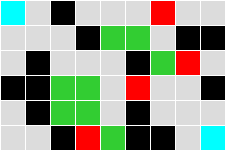

In [10]:
# Define the maze and visually verify the availability of a path from start to finish

rows = 6
cols = 9
fractions = [0.3,0.1,0.2]
seed_env = 2

Env_Maze(rows, cols, fractions, seed_env).rgb_view()

In [11]:
# Set agent parameters

epsilon = 0.15 
discount = 0.95
step_size = 0.5

In [12]:
# Set number of episodes and experiments

num_episodes = 30
num_exp = 50 

In [12]:
# Run and average the experiments

# Dictinaries to hold the outputs of interest
A, B, C, D = {}, {}, {}, {}

# Loop across the 3 TD control algorithms
for algo in tqdm(["Q-Learning", "SARSA", "Expected SARSA"]):
    
    # Start the scores and episode length matrices
    scores_matrix = np.empty((0, num_episodes))
    episode_length_matrix = np.empty((0, num_episodes))

    # Run num_exp number of experiments for each algorithm
    for exp in tqdm(range(num_exp), leave=False):
        
        # Restart the RL loop class for each experiment
        m= RL(rows, cols, fractions, seed_env, 
             epsilon, discount, step_size, seed_agent=exp)
        
        # Frames and trajectory are only stored for the last experiment 
        save_fr = True if exp == num_exp - 1 else False
        
        # Run a single experiment
        scores, episode_lengths = m.run_exp(algo,num_episodes, save_fr)
        
        # Stack rows to scores and episode length matrices for each experiment
        scores_matrix = np.vstack((scores_matrix, np.array(scores)))
        episode_length_matrix = np.vstack((episode_length_matrix, np.array(episode_lengths)))
        
    # Determine for each algorithm:
    
    # Average of scores for each episode    
    A[algo] = np.mean(scores_matrix, axis=0)
    
    # Average of episode lengths for each episode
    B[algo] = np.mean(episode_length_matrix, axis=0)
    
    # Trajectories of the first and last episodes for the last experiment
    C[algo] = m.traj_dict
    
    # Movies of the first and last episodes for the last experiment
    D[algo] = m.fr_dict
    for key in D[algo].keys():
        m.make_gif(D[algo][key],f".\\images\\{algo}_last_exp_episode_{key}.gif")

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

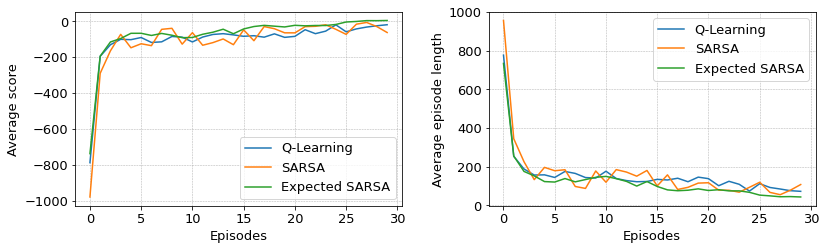

In [13]:
# Average score and episode length vs. number of episodes for the 3 TD algorithms

plot_episodes(num_episodes,A,B)

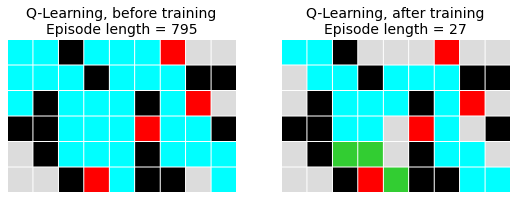

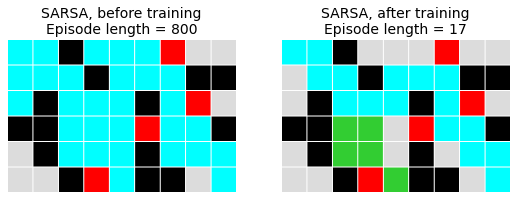

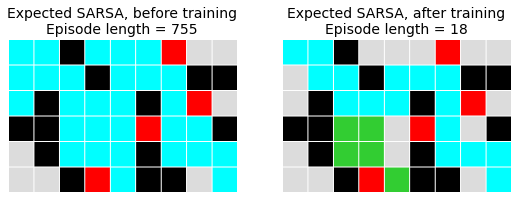

In [14]:
# Agent's trajectory before and after training for the 3 TD algorithms

plot_trajectories(num_episodes)

In [15]:
# Agent's animated journey before and after training for the 3 TD algorithms

display_gifs(num_episodes)
# Not rendered by GitHub but it works when you run the notebook